In [1]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [2]:
# import system_message.txt as a string
with open('prompts/system_qna_rating.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze the last earnings call transcripts before default of companies and extract specific features related to Analyst Questions and Management Responses. These features will be used to predict the recovery rate of bonds (the 30-day average bond price after default) issued by these companies.

Objective:
Given the provided earnings call transcript, perform the following tasks:

Separate Analyst Questions and Management Responses:
Identify and separate the sections of the transcript that contain analyst questions and management responses during the Q&A session.
Extract Features Related to Analyst Questions:
[Score1] Severity of Analyst Concerns (0.00 - 1.00):
Identify the main topics and concerns raised by analysts.
Assign a score based on the relevance and seriousness of these concerns regarding the company's financial health and recovery prospects.
A higher score indicates that anal

In [3]:
transcripts = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

# drop rows where presentation_cleaned is ''
transcripts = transcripts.dropna(subset=['QnA'])

# add a number to each transcript based on the 196 unique transcripts
transcripts['transcript_number'] = transcripts['QnA'].factorize()[0]

number_transcript = transcripts[['transcript_number', 'QnA']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

,transcript_number,QnA
0,0,question and answer\noperator\n[operator instr...
1,1,question and answer\noperator\n(operator instr...
2,2,question and answer\noperator\nthank you. ladi...
3,3,question and answer\noperator\n[operator instr...
4,4,question and answer\noperator\n(operator instr...


In [4]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

output = []

In [31]:
for i in number_transcript['QnA']:
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": i}
            ]
        )
        output.append(completion.choices[0].message.content)
        print(len(output))
        print(completion.choices[0].message.content)
    except openai.error.OpenAIError as e:
        print(f"An exception occurred: {e}")
        print("Waiting for 1 minute before retrying...")
        time.sleep(60)


1
0.70; 0.80; 0.20; 0.75; 0.65
2
0.75; 0.70; 0.60; 0.80; 0.65
3
0.75; 0.70; 0.60; 0.80; 0.65
4
0.80; 0.70; 0.60; 0.75; 0.65
5
0.75; 0.70; 0.60; 0.80; 0.65
6
0.75; 0.50; 0.80; 0.60; 0.40
7
0.75; 0.80; 0.60; 0.70; 0.65
8
0.80; 0.60; 0.70; 0.50; 0.40
9
0.85; 0.70; 0.60; 0.75; 0.65
10
0.75; 0.80; 0.60; 0.70; 0.65
11
0.60; 0.80; 0.20; 0.70; 0.50
12
0.75; 0.60; 0.40; 0.70; 0.50
13
0.75; 0.80; 0.20; 0.70; 0.65
14
0.75; 0.80; 0.30; 0.70; 0.60
15
0.75; 0.80; 0.30; 0.70; 0.60
16
0.75; 0.60; 0.70; 0.80; 0.65
17
0.75; 0.80; 0.20; 0.70; 0.60
18
0.70; 0.80; 0.20; 0.60; 0.50
19
0.75; 0.80; 0.60; 0.70; 0.65
20
0.85; 0.75; 0.60; 0.80; 0.70
21
0.75; 0.80; 0.20; 0.70; 0.60
22
0.75; 0.80; 0.60; 0.70; 0.65
23
0.75; 0.80; 0.20; 0.70; 0.60
24
0.75; 0.60; 0.70; 0.65; 0.50
25
0.75; 0.80; 0.30; 0.70; 0.60
26
0.75; 0.70; 0.30; 0.80; 0.65
27
0.85; 0.70; 0.60; 0.75; 0.65
28
0.75; 0.70; 0.40; 0.60; 0.50
29
0.75; 0.80; 0.20; 0.70; 0.60
30
0.75; 0.80; 0.20; 0.60; 0.65
31
0.75; 0.70; 0.60; 0.80; 0.65
32
0.80; 0.70; 0.

In [32]:
# Initialize the DataFrame with the new columns
output_df = pd.DataFrame(columns=[
    'severity', 'responsiveness', 'evasiveness', 'allignment', 'sentiment'
])

# Parse the output list and populate the DataFrame
output_df['severity'] = [float(i.split('; ')[0]) for i in output]
output_df['responsiveness'] = [float(i.split('; ')[1]) for i in output]
output_df['evasiveness'] = [float(i.split('; ')[2]) for i in output]
output_df['allignment'] = [float(i.split('; ')[3]) for i in output]
output_df['sentiment'] = [float(i.split('; ')[4]) for i in output]

# Display the DataFrame
output_df


,severity,responsiveness,evasiveness,allignment,sentiment
0,0.70,0.8,0.2,0.75,0.65
1,0.75,0.7,0.6,0.80,0.65
2,0.75,0.7,0.6,0.80,0.65
3,0.80,0.7,0.6,0.75,0.65
4,0.75,0.7,0.6,0.80,0.65
...,...,...,...,...,...
191,0.75,0.7,0.4,0.60,0.50
192,0.60,0.8,0.2,0.70,0.50
193,0.75,0.8,0.2,0.70,0.65
194,0.75,0.7,0.3,0.60,0.65


In [33]:
output_df['transcript_number'] = output_df.index

# merge output_df with transcripts on 'transcript_number' and index
transcripts = pd.merge(transcripts,
                          output_df,
                          on='transcript_number',
                          how='left')

checkpoint = transcripts.copy()

In [151]:
# save checkpoint as csv
checkpoint.to_csv('transcripts/LLM_outputs_QnA.csv', index=False)
checkpoint = pd.read_csv('transcripts/LLM_outputs_QnA.csv')

In [44]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

llm_labels = ['severity', 'responsiveness', 'evasiveness', 'allignment']

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    + supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

final_df.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Date,CBOE DJIA Volatility Index,NASDAQ 100 Index return,Manufacturers inventories to sales ratio,30 year conventional mortgage rate,Communication Services,Consumer Discretionary,Senior secured,Time to maturity,Equity value,...,Energy,Health Care,Utilities,Information Technology,Real Estate,severity,responsiveness,evasiveness,allignment,RR
0,2006-12-01,23.14,0.085368,1.39,5.20,0,1,0,3014,635.12600,...,0,0,0,0,0,0.70,0.8,0.2,0.75,29.023972
1,2007-11-06,44.28,-0.025915,1.46,5.01,0,0,0,6361,0.00000,...,0,0,0,1,0,0.75,0.7,0.6,0.80,8.869420
2,2008-01-25,20.29,0.076193,1.20,5.88,0,0,0,6458,228.77559,...,0,0,0,0,0,0.75,0.7,0.6,0.80,33.210455
3,2008-01-28,19.49,-0.096174,1.20,6.08,0,0,0,1502,-91.83100,...,0,0,0,0,0,0.80,0.7,0.6,0.75,11.875000
4,2008-01-30,19.92,0.006565,1.20,6.26,0,0,0,1288,-96.67500,...,0,0,0,0,0,0.75,0.7,0.6,0.80,18.340000


In [45]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     43.45
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           8.15e-34
Time:                        11:53:40   Log-Likelihood:                -4940.9
No. Observations:                1075   AIC:                             9892.
Df Residuals:                    1070   BIC:                             9917.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             97.7154     11.709      8.

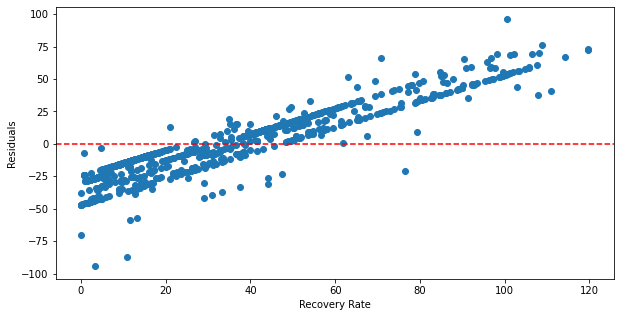

In [41]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [42]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

         Features         VIF
0           const  255.127403
1        severity    3.152554
4      allignment    2.911932
3     evasiveness    2.482756
2  responsiveness    1.727086


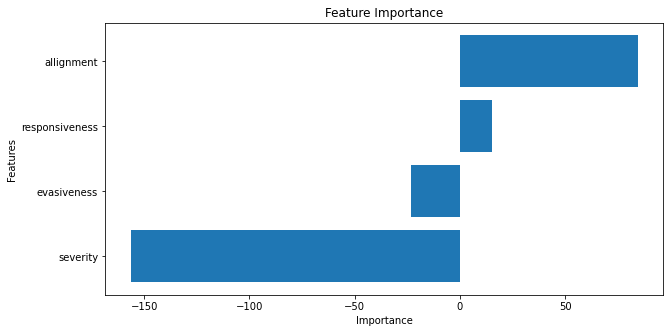

In [43]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()